In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import sampler

Load and process CIFAR 10 data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

Files already downloaded and verified
Files already downloaded and verified


Look at example CIFAR images

<IPython.core.display.Javascript object>


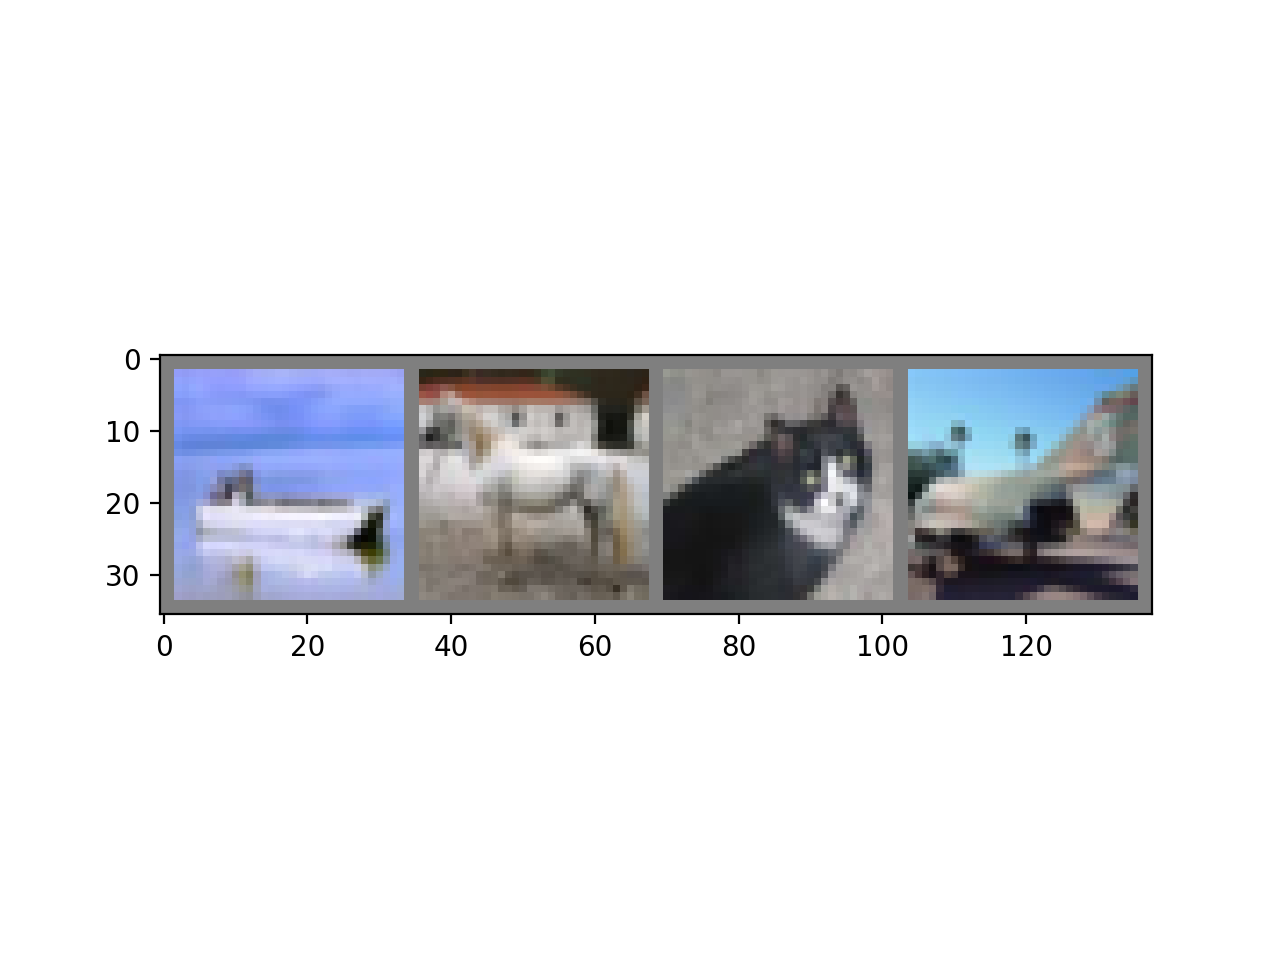

 ship horse   cat plane


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
  File "/usr/local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50

In [3]:
%matplotlib nbagg
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [38]:
import torch.utils.model_zoo as model_zoo
vgg_model = vgg_lite()
# sd = model_zoo.load_url('https://download.pytorch.org/models/vgg11-bbd30ac9.pth')
# #fix naming issue 
# sd['classifier.1.weight'] = sd['classifier.0.weight']
# sd['classifier.1.bias'] = sd['classifier.0.bias']
# del sd['classifier.0.weight']
# del sd['classifier.0.bias']

# sd['classifier.4.weight'] = sd['classifier.3.weight']
# sd['classifier.4.bias'] = sd['classifier.3.bias']
# del sd['classifier.3.weight']
# del sd['classifier.3.bias']
# vgg_model.load_state_dict()

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

In [173]:
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for t, (x, y) in enumerate(trainloader):
        inputs, labels = to_var(x), to_var(y.long())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if t % 1000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, t + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.371
[1,  1001] loss: 287.384
[1,  2001] loss: 280.407
[1,  3001] loss: 278.158
[1,  4001] loss: 278.036
[1,  5001] loss: 272.872
[1,  6001] loss: 275.708
[1,  7001] loss: 271.021
[1,  8001] loss: 274.121
[1,  9001] loss: 262.744
[1, 10001] loss: 268.781
[1, 11001] loss: 265.009
[1, 12001] loss: 259.478
[2,     1] loss: 0.131
[2,  1001] loss: 262.410
[2,  2001] loss: 253.960
[2,  3001] loss: 253.751
[2,  4001] loss: 256.330
[2,  5001] loss: 255.047
[2,  6001] loss: 248.750
[2,  7001] loss: 245.034
[2,  8001] loss: 242.157
[2,  9001] loss: 240.525
[2, 10001] loss: 240.978
[2, 11001] loss: 237.635
[2, 12001] loss: 233.451
[3,     1] loss: 0.243
[3,  1001] loss: 236.029
[3,  2001] loss: 232.008
[3,  3001] loss: 228.009
[3,  4001] loss: 224.230
[3,  5001] loss: 227.887
[3,  6001] loss: 223.003
[3,  7001] loss: 221.278
[3,  8001] loss: 220.241
[3,  9001] loss: 216.558
[3, 10001] loss: 211.881
[3, 11001] loss: 214.874
[3, 12001] loss: 212.208
Finished Training


In [174]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = vgg_model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 10 %


In [183]:
list(vgg_model.children())[0][0].weight.data


(0 ,0 ,.,.) = 
  0.5340  1.2478  1.5036
  0.0496  0.0021 -0.4660
 -1.0139 -0.2640 -0.4929

(0 ,1 ,.,.) = 
 -0.1170 -0.4953 -0.4899
 -0.2958 -0.8115 -0.2507
  0.2518 -0.1058  0.0120

(0 ,2 ,.,.) = 
 -0.1335  0.1713 -0.2262
 -0.4658 -0.0412 -0.2710
  0.6554  0.6911  0.1746

(1 ,0 ,.,.) = 
 -0.6593 -0.2206 -0.3797
 -0.6596 -0.4223 -0.9046
  0.0744 -0.1373 -0.4615

(1 ,1 ,.,.) = 
  0.5470  0.3200  0.4941
 -0.6826 -0.3782 -0.0962
 -0.4190  0.4516  0.2474

(1 ,2 ,.,.) = 
  0.8824  0.7415  0.9588
 -0.0318  0.2759 -0.2392
  0.4855  0.2995  0.7300
[torch.FloatTensor of size 2x3x3x3]

In [176]:
prune_rate(vgg_model)

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 0.00% parameters pruned
Layer 10 | Linear layer | 0.00% parameters pruned
Layer 11 | Linear layer | 0.00% parameters pruned
Final pruning rate: 0.00%


0.0

<IPython.core.display.Javascript object>


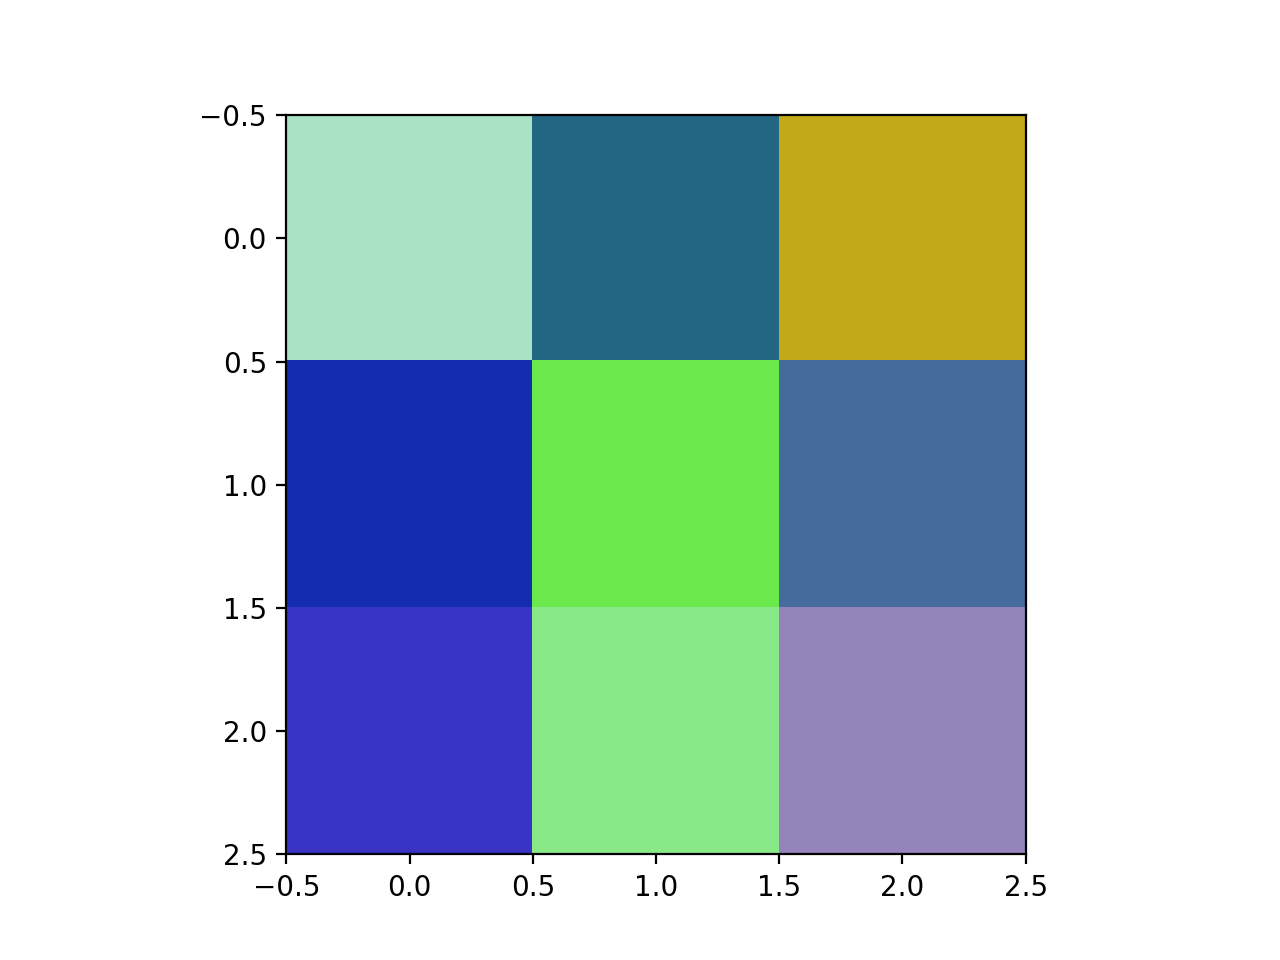

In [34]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
mm = vgg_model.double()
filters = mm.modules
body_model = [i for i in mm.children()][0]
layer1 = body_model[0]
tensor = layer1.weight.data.numpy()
plt.figure()
plt.imshow(tensor[0])


In [37]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model = vgg_model.double()
for data in testloader:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


RuntimeError: Expected object of type torch.FloatTensor but found type torch.DoubleTensor for argument #2 'weight'

In [6]:
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

def prune_rate(model, verbose=True):
    """
    adapted from 
    """
    total_nb_param = 0
    nb_zero_param = 0

    layer_id = 0

    for parameter in model.parameters():

        param_this_layer = 1
        for dim in parameter.data.size():
            param_this_layer *= dim
        total_nb_param += param_this_layer

        # only pruning linear and conv layers
        if len(parameter.data.size()) != 1:
            layer_id += 1
            zero_param_this_layer = \
                np.count_nonzero(parameter.cpu().data.numpy()==0)
            nb_zero_param += zero_param_this_layer

            if verbose:
                print("Layer {} | {} layer | {:.2f}% parameters pruned" \
                    .format(
                        layer_id,
                        'Conv' if len(parameter.data.size()) == 4 \
                            else 'Linear',
                        100.*zero_param_this_layer/param_this_layer,
                        ))
    pruning_perc = 100.*nb_zero_param/total_nb_param
    if verbose:
        print("Final pruning rate: {:.2f}%".format(pruning_perc))
    return pruning_perc

In [7]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
        
        
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        

In [185]:
class PruneWrapSparse():# could also use this to maks out entire filters accoring to taylor criterion
    def __init__(self,epoch_start,model,sparsity_initial,sparsity_target,prune_steps,update_rate,train,gpu=False):
        #model params
        self.model = model.float()
        self.gpu = gpu
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_loader = train
        
        #bookkeeping
        self.current_sparsity=0
        self.sparsity_target = sparsity_target
        self.sparsity_initial = sparsity_initial
        self.train_step = epoch_start
        self.prune_steps =prune_steps
        self.update_rate = update_rate
        self.prunning = True
        
    def to_string(self):
        print "current sparsity: " + str(self.current_sparsity)
        print "sparsity target: "+ str(self.sparsity_target)
        print "initial sparsity: " + str(self.sparsity_initial)
        print "current train step: "+ str(self.train_step)
        print "prune steps: "+str(self.prune_steps)
        print "prunning rate: "+str(self.update_rate)
        
    def test(self,test_data_loader):
        self.model.eval()
        correct = 0
        total = 0
        for i, (batch, label) in enumerate(test_data_loader):
            batch,label = (batch.cuda(),label.cuda()) if self.gpu else (batch,label)
            output = self.model(Variable(batch.float()))
            pred = output.data.max(1)[1]
            correct += pred.cpu().eq(label).sum()
            total += label.size(0)
        print "acc :", float(correct) / total
    
    def reset(self):
        self.current_sparsity=0
        self.prune_step =0
    
    def compute_current_target(self):
        return self.sparsity_target+(self.sparsity_initial-self.sparsity_target)*(1-self.train_step/(self.prune_steps*self.train_step))**3
    
    def train(self, optimizer = None, epoches = 10):
        start = time.time()
        if optimizer is None:
            optimizer = optim.SGD(self.model.classifier.parameters(), lr=0.0001, momentum=0.9)
        for i in range(epoches):
            print self.to_string()
            print "epoch: ", i
            print self.current_sparsity
            for batch, label in self.train_loader:
                if self.current_sparsity >= self.sparsity_target:
                    self.prunning = False
                batch,label = (batch.cuda(),label.cuda()) if self.gpu else (batch,label)
                input = Variable(batch)
                if self.prunning and self.train_step%self.update_rate==0:
                    self.prune()
                self.criterion(self.model(input), Variable(label)).backward()
                optimizer.step()
                self.train_step+=1
            print prune_rate(self.model)
            print self.test(testloader)
        print "Finished fine tuning."
        print "Time elapsed:" + str((time.time() - start))
    
    def prune(self):#all conv layers for now
        current_sparsity_target = self.compute_current_target()
        for seq in list(self.model.children()):
            for layer in seq:
                if isinstance(layer, MaskedConv2d) or isinstance(layer, MaskedLinear):
                    #find weight threshold for layer
                    weight_threshold = self.get_weight_threshold(layer.parameters(),current_sparsity_target) 
                    #set mask
                    mask = self.get_prune_mask(layer,weight_threshold)
                    #prune
                    layer.set_mask(mask)
        self.current_sparsity = current_sparsity_target
       
    def get_prune_mask(self,layer,threshold):
        # generate mask
        p=layer.weight.data.abs()
        pruned_inds = p > threshold
        return pruned_inds.float()
        
    def save_weight_hist(self,params):
        params = []
        plt.figure()
        for p in self.model.parameters():
            params.extend(list(p.data.abs().numpy().flatten()))
        plt.hist(params,bins=100,range=[0, 1])
        plt.show()
        
    def get_weight_threshold(self,params,percent_to_prune):
        weights=[]
        for param in params:
            if len(list(param.cpu().data.abs().numpy().flatten()))>1:
                weights.extend(list(param.cpu().data.abs().numpy().flatten()))
        threshold = np.percentile(np.array(weights),percent_to_prune*100)
        #print len(np.nonzero(np.array(weights)))/float(len(weights))
        return threshold
    
    def calculate_current_model_size(self):
        modules = list(self.model.modules())
        for i in range(1,len(modules)):
            model_sizes = []
            current_mod = modules[i]
            params = list(current_mod.parameters())
            for j in range(len(params)):
                model_sizes.append(np.array(params[j].size()))

        num_bits = 0
        bits = 32 #32 bit floats
        for i in range(len(model_sizes)):
            s = model_sizes[i]
            bits = np.prod(np.array(s))*bits
            num_bits += bits
        print(num_bits)
        return num_bits
    
    def calculate_current_model_inference_time(self,samples=10):
        time_sum =0
        for i in range(samples):
            (batch, label) = next(iter(self.train_loader))
            input = Variable(batch.float())
            start = time.time()
            output = self.model(input)
            time_sum+=time.time() - start
        print "Time elapsed:" + str((time_sum/float(samples)))

            
            

In [186]:
prune = PruneWrapSparse(2,vgg_model,0,.2,10,2,trainloader)
prune.calculate_current_model_size()
prune.calculate_current_model_inference_time(10)

56320
Time elapsed:0.00792138576508


<IPython.core.display.Javascript object>


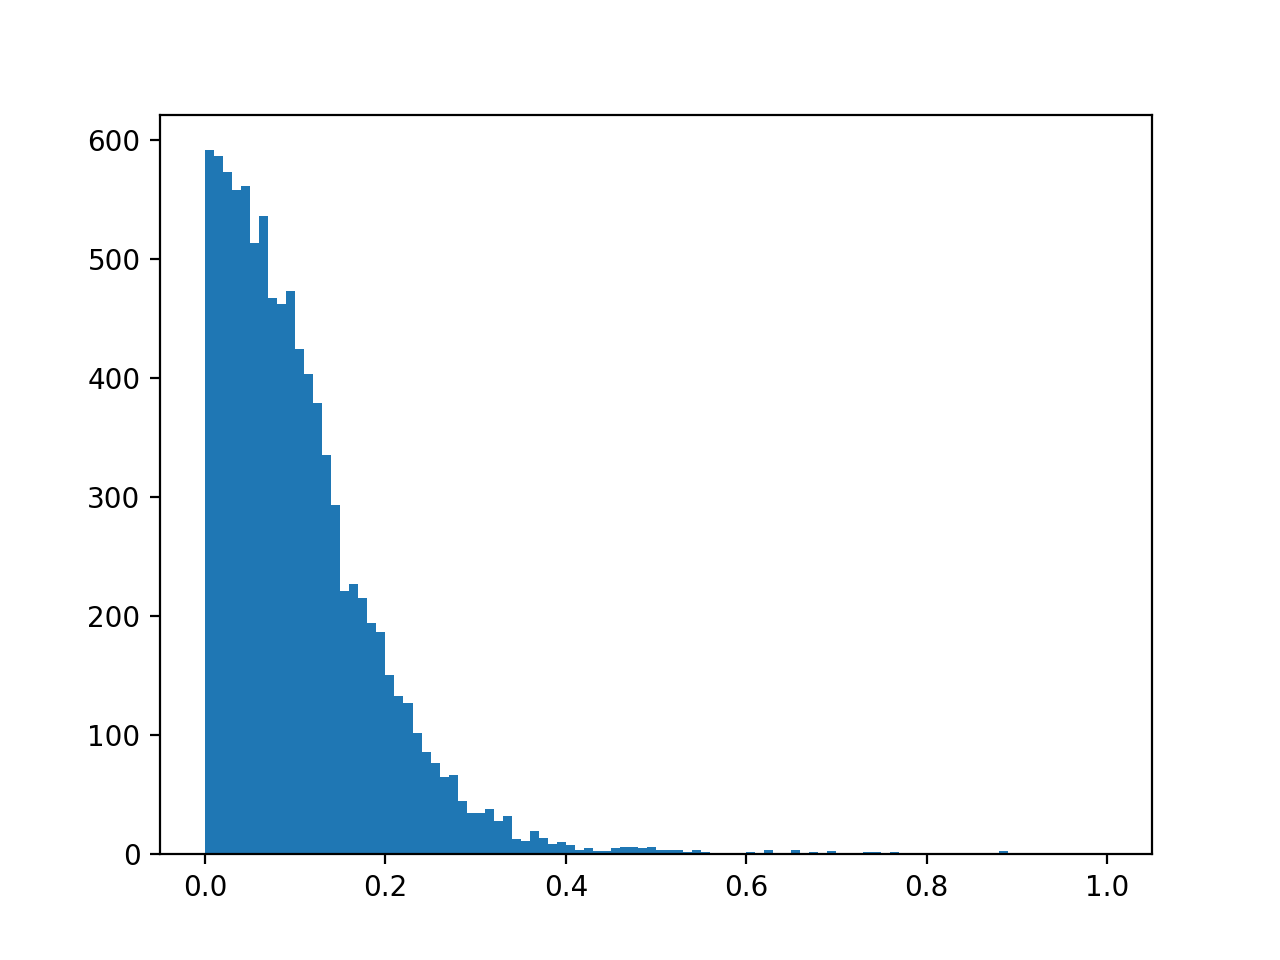

In [187]:
params = []
plt.figure()
for p in vgg_model.parameters():
    params.extend(list(p.data.abs().numpy().flatten()))
plt.hist(params,bins=100,range=[0, 1])
plt.show()
        

In [172]:
prune.test(testloader)

acc : 0.1


In [188]:
prune.train()#nonzeros vs zeroing out in forward pass

current sparsity: 0
sparsity target: 0.2
initial sparsity: 0
current train step: 2
prune steps: 10
prunning rate: 2
None
epoch:  0
0
Layer 1 | Conv layer | 1.85% parameters pruned
Layer 2 | Conv layer | 1.39% parameters pruned
Layer 3 | Conv layer | 0.35% parameters pruned
Layer 4 | Conv layer | 0.17% parameters pruned
Layer 5 | Conv layer | 0.09% parameters pruned
Layer 6 | Conv layer | 0.04% parameters pruned
Layer 7 | Conv layer | 0.04% parameters pruned
Layer 8 | Conv layer | 0.04% parameters pruned
Layer 9 | Linear layer | 0.39% parameters pruned
Layer 10 | Linear layer | 0.39% parameters pruned
Layer 11 | Linear layer | 0.62% parameters pruned
Final pruning rate: 0.11%
0.111629795007
acc : 0.1
None
current sparsity: 0.0
sparsity target: 0.2
initial sparsity: 0
current train step: 12502
prune steps: 10
prunning rate: 2
None
epoch:  1
0.0
Layer 1 | Conv layer | 1.85% parameters pruned
Layer 2 | Conv layer | 1.39% parameters pruned
Layer 3 | Conv layer | 0.35% parameters pruned
Laye

In [42]:

# Hyper Parameters
param = {
    'pruning_perc': 90.,
    'batch_size': 128, 
    'test_batch_size': 100,
    'num_epochs': 5,
    'learning_rate': 0.001,
    'weight_decay': 5e-4,
}

# prune the weights
masks = weight_prune(vgg_model, param['pruning_perc'])
vgg_model.set_masks(masks)
print("--- {}% parameters pruned ---".format(param['pruning_perc']))
test(vgg_model, testloader)


# Retraining
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=param['learning_rate'], 
                                weight_decay=param['weight_decay'])

train(net, criterion, optimizer, param, loader_train)


# Check accuracy and nonzeros weights in each layer
print("--- After retraining ---")
test(net, loader_test)
prune_rate(net)


# Save and load the entire model
torch.save(net.state_dict(), 'vgg_pruned.pkl')

AttributeError: 'VGG' object has no attribute 'set_masks'

In [10]:
'''
Modified from https://github.com/pytorch/vision.git
'''
import math
import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]
#make vgg with masked layers
class VGG(nn.Module):
    def __init__(self, features,width=512):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            MaskedLinear(width, width),
            nn.ReLU(True),
            nn.Dropout(),
            MaskedLinear(width, width),
            nn.ReLU(True),
            MaskedLinear(width, 10),
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = MaskedConv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
    'T': [2, 'M', 4, 'M', 8, 8, 'M', 16, 16, 'M', 16, 16, 'M'],
}
def vgg_lite():
    return VGG(make_layers(cfg['T']),width=16)

def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))

def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

### adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

notes:

questions?:
    1. Data involved or data agnostic
    2. during training or after
    3. Inference citeria, or backprop criteria.
    4. at what point during training do you prune
    5. using gradient and activation signals if one is high
    6. train from scratch work or need long burn in time
    7. VGG is notoriously slow to train with large memory footprint, what about squeeznet, arcitectures that are just better
    8. layerwise or globally
    9. when using speed as metric have to make sure your prunning method is super efficient
 Channel-wise
 10. if not layerwise how do params get masked over time, in what layersc
SSL [49] reaches high compression ratio for first few conv
layers of LeNet [30] and AlexNet [26]. [54] could work
well for fully connected layers. However, training-based
approaches are more costly, and the effectiveness for very
deep networks on large datasets is rarely exploited

